# Format Data and compute valence for each fragmetned song

## Load EmotionWave library and datasets

In [ ]:
# @title Install and load libraries { display-mode: "form" }
# @markdown The following libraries and programs will be installed:
# @markdown - MIDItok (tokeniser)
# @markdown - Fluidsynth (MIDI to wav)
# @markdown - Muspy (Symbolic music libraries handle)
# @markdown ---
# @markdown All necessary libraries are included in this cell

# Install MIDItok for tokenising MIDI files
!pip install miditok
# Library used to handle symbolic music datasets. Used in this case for
# Emopia and Maestro datasets
!pip install muspy
# Fluidsynth for producing wav files from midi (using a soundfont)
!pip install midi2audio
!pip install fluidsynth
# Install fluidsynth
!apt install fluidsynth
# Copy default sample of musical instruments to current directory
#!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

# Using REMI scheme tokenisation
from miditok import REMI, TokenizerConfig
# Manage paths
from pathlib import Path
import os
# Ipython.display to show audio files
import IPython.display as ipd
# Librosa for music and audio analysis
import librosa
# Symbolic music datasets library
import muspy
# To calculate information from the midi file
import music21
# To copy objects
import copy
# Pytorch
import torch

# Set datasets path
datasets_folder = 'data'
vgmidi_path  = datasets_folder + '/vgmidi'
emopia_path  = datasets_folder + '/emopia'
maestro_path = datasets_folder + '/maestro'

# Create folder for datasets
if not os.path.exists(datasets_folder):
    os.makedirs(datasets_folder)

  Using cached miditok-3.0.3-py3-none-any.whl.metadata (9.0 kB)
  Using cached symusic-0.5.1-cp310-cp310-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (10 kB)
  Using cached tokenizers-0.20.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached pySmartDL-1.3.4-py3-none-any.whl.metadata (2.8 kB)
Using cached miditok-3.0.3-py3-none-any.whl (130 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 6.5 MB/s eta 0:00:00:00:01
Using cached symusic-0.5.1-cp310-cp310-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (2.5 MB)
Using cached tokenizers-0.20.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.9 MB)
Using cached pySmartDL-1.3.4-py3-none-any.whl (20 kB)

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
  Using cached muspy-0.5.0-py3-none-any.whl.metadata (5.5 kB)
  Using cached bidict-0.23.1-py3-none-any.whl.metadata (8.7 kB)
  Using cached miditoolkit-1.0.

In [ ]:
# @title Get datasets { display-mode: "form" }
# @markdown Datasets to download:
# @markdown - VGMIDI (from github)
# @markdown - EMOPIA (muspy)
# @markdown - MAESTRO (muspy)
!git clone https://github.com/lucasnfe/vgmidi.git {vgmidi_path}
# Extract unlabelled midi from VGMIDI dataset
!unzip "{vgmidi_path}/unlabelled/midi.zip" -d "{vgmidi_path}/"

# Use muspy library for emopia and maestro datasets
emopia = muspy.EMOPIADataset(emopia_path, download_and_extract=True)
maestro = muspy.datasets.MAESTRODatasetV3(maestro_path, download_and_extract=True)

# Get paths of unlabelled data in VGMIDI dataset
vgmidi_unlabelled_midi_paths = list(Path("./data/vgmidi/midi").glob("*.mid"))
print("VGMIDI unlabelled paths", len(vgmidi_unlabelled_midi_paths))

# Get paths of labelled data in VGMIDI dataset
vgmidi_labelled_midi_paths = list(Path("./data/vgmidi/labelled/midi").glob("*.mid"))
print("VGMIDI labelled paths", len(vgmidi_labelled_midi_paths))

# Get paths of labelled data in EMOPIA dataset
emopia_labelled_midi_paths = list(Path("./data/emopia/EMOPIA_2.2/midis").glob("*.mid"))
print("EMOPIA labelled paths", len(emopia_labelled_midi_paths))

# Create list to store MAESTRO dataset paths
maestro_unlabelled_midi_paths = list()
# Get paths of unlabelled data in MAESTRO dataset
for folder in os.listdir("./data/maestro/maestro-v3.0.0/"):
  maestro_unlabelled_midi_paths +=  list(Path("./data/maestro/maestro-v3.0.0/" + folder).glob("*.mid*"))
print("MAESTRO labelled paths", len(maestro_unlabelled_midi_paths))

# Create list of combined laballed paths
combined_labelled_dataset_paths = vgmidi_labelled_midi_paths + emopia_labelled_midi_paths
print("Combined labelled paths", len(combined_labelled_dataset_paths))

# Create list of combined unlabelled paths
combined_unlabelled_dataset_paths = vgmidi_unlabelled_midi_paths + maestro_unlabelled_midi_paths
print("Combined unlabelled paths", len(combined_unlabelled_dataset_paths))

# Create list of combined labelled and unlabelled paths
combined_dataset_paths = combined_unlabelled_dataset_paths + combined_labelled_dataset_paths
print("Combined paths", len(combined_dataset_paths))

Skip downloading as the `.muspy.success` file is found.
Skip extracting as the `.muspy.success` file is found.
Skip downloading as the `.muspy.success` file is found.
Skip extracting as the `.muspy.success` file is found.
VGMIDI unlabelled paths 3850
VGMIDI labelled paths 204
EMOPIA labelled paths 1071
MAESTRO labelled paths 1276
Combined labelled paths 1275
Combined unlabelled paths 5126
Combined paths 6401


In [ ]:
import importlib
import EmotionWave.MIDIoperations
from EmotionWave.MIDIoperations import REMItokenizer, MidiWav
import pretty_midi
from midi2audio import FluidSynth

# Reload the module
importlib.reload(EmotionWave.MIDIoperations)

# Our parameters
TOKENIZER_PARAMS = {
    "pitch_range": (21, 109),
    "beat_res": {(0, 4): 8, (4, 12): 4},
    "num_velocities": 32,
    "special_tokens": ["BOS", "EOS", "MASK"],
    "use_chords": True,
    "use_rests": False,
    "use_tempos": True,
    "use_time_signatures": True,
    "use_programs": False,
    "use_pitchdrum_tokens": False,
    "num_tempos": 32,  # number of tempo bins
    "tempo_range": (40, 250),  # (min, max)
}

# Load tokeniser
remi = REMItokenizer(TOKENIZER_PARAMS, max_bar_embedding=None)

# Divide songs from all datasets in Fragments of 8 bars and one track. A distinction is made for each labelled dataset
remi.divide_songs_in_fragments_from_dataset(vgmidi_labelled_midi_paths, 'FolderD0/', number_of_tracks=1)
remi.divide_songs_in_fragments_from_dataset(vgmidi_unlabelled_midi_paths, 'FolderD1/', number_of_tracks=1)
remi.divide_songs_in_fragments_from_dataset(maestro_unlabelled_midi_paths, 'FolderD2/', number_of_tracks=1)
remi.divide_songs_in_fragments_from_dataset(emopia_labelled_midi_paths, 'FolderD3/', number_of_tracks=1)

{'BOS_None': 0, 'EOS_None': 1, 'MASK_None': 2, 'PAD_None': 3, 'Bar_None': 4, 'Pitch_21': 5, 'Pitch_22': 6, 'Pitch_23': 7, 'Pitch_24': 8, 'Pitch_25': 9, 'Pitch_26': 10, 'Pitch_27': 11, 'Pitch_28': 12, 'Pitch_29': 13, 'Pitch_30': 14, 'Pitch_31': 15, 'Pitch_32': 16, 'Pitch_33': 17, 'Pitch_34': 18, 'Pitch_35': 19, 'Pitch_36': 20, 'Pitch_37': 21, 'Pitch_38': 22, 'Pitch_39': 23, 'Pitch_40': 24, 'Pitch_41': 25, 'Pitch_42': 26, 'Pitch_43': 27, 'Pitch_44': 28, 'Pitch_45': 29, 'Pitch_46': 30, 'Pitch_47': 31, 'Pitch_48': 32, 'Pitch_49': 33, 'Pitch_50': 34, 'Pitch_51': 35, 'Pitch_52': 36, 'Pitch_53': 37, 'Pitch_54': 38, 'Pitch_55': 39, 'Pitch_56': 40, 'Pitch_57': 41, 'Pitch_58': 42, 'Pitch_59': 43, 'Pitch_60': 44, 'Pitch_61': 45, 'Pitch_62': 46, 'Pitch_63': 47, 'Pitch_64': 48, 'Pitch_65': 49, 'Pitch_66': 50, 'Pitch_67': 51, 'Pitch_68': 52, 'Pitch_69': 53, 'Pitch_70': 54, 'Pitch_71': 55, 'Pitch_72': 56, 'Pitch_73': 57, 'Pitch_74': 58, 'Pitch_75': 59, 'Pitch_76': 60, 'Pitch_77': 61, 'Pitch_78': 62, 

(2925, 2925)

In [ ]:
import importlib
import EmotionWave.MIDIoperations
from EmotionWave.MIDIoperations import REMItokenizer, MidiWav
import pretty_midi
from midi2audio import FluidSynth

# Reload the module
importlib.reload(EmotionWave.MIDIoperations)

# Remove not 4/4 fragments
vgmidil_paths = list(Path("./FolderD0").glob("*.mid"))
vgmidiu_paths = list(Path("./FolderD1").glob("*.mid"))
maestro_paths = list(Path("./FolderD2").glob("*.mid"))
emopia_paths = list(Path("./FolderD3").glob("*.mid"))

# Get all fragmented paths in one list
fragmented_paths = vgmidil_paths + vgmidiu_paths + maestro_paths + emopia_paths

print("Size of data", len(fragmented_paths))

# Our parameters
TOKENIZER_PARAMS = {
    "pitch_range": (21, 109),
    "beat_res": {(0, 4): 8, (4, 12): 4},
    "num_velocities": 32,
    "special_tokens": ["BOS", "EOS", "MASK"],
    "use_chords": True,
    "use_rests": False,
    "use_tempos": True,
    "use_time_signatures": True,
    "use_pitchdrum_tokens": False,
    "use_programs": False,
    "num_tempos": 32,  # number of tempo bins
    "tempo_range": (40, 250),  # (min, max)
}

remi = REMItokenizer(TOKENIZER_PARAMS, max_bar_embedding=None)

# Create a folder if it does not exist
if not os.path.exists("./FilteredD"):
    os.makedirs("./FilteredD")

i = 0
count_4 = 0

# FilterD will contain all the 4/4 fragmented pieces
dir_path = './FilteredD/'

# Go through all the tokens an filter based on the time signature
for file_path in fragmented_paths:
    try:
        tkn = remi.tokenize_midi_file(file_path)
        # Filter based on 4/4 time signature
        if tkn[0].tokens[1] in "TimeSig_4/4":
            # Extract file name
            file_name = os.path.basename(file_path)
            # Save the new MIDI file
            truncated_midi_path = dir_path + file_name
            remi.tokens_to_midi(truncated_midi_path, tkn)
            # Keep track of 4/4 tracks
            count_4 += 1
    except:
        print("Error")
    i += 1
    if i % 5000 == 0:
        print("Processed", i)

# Filter song to just 4/4
print("Total songs 4/4 of 8 bars", count_4)

Size of data 75941
Processed 5000
Error
Processed 10000
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


## ValenceNet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Load valence labeled fragments from VGMIDI and EMOPIA
vgmidi_paths = list(Path("./FolderD0").glob("*.mid"))
emopia_paths = list(Path("./FolderD3").glob("*.mid"))
print("VGMIDI labeled fragments", len(vgmidi_paths))
print("EMOPIA labeled fragments", len(emopia_paths))

VGMIDI labeled fragments 247
EMOPIA labeled fragments 2925


In [ ]:
from music21 import converter, analysis, chord, meter, note
from mido import MidiFile
import mido
from collections import defaultdict
import numpy as np
import pandas as pd
import time
import re
import numpy as np
from scipy.signal import find_peaks

# Get Mode by analysing the key
def get_mode(midi_file):
    try:
        # Convert midi file to a score using music21
        score = converter.parse(midi_file)
        # Get the key
        key = score.analyze('key')
        # Return the key mode
        return key.mode
    # There is no key
    except Exception as e:
        print(f"Error processing {midi_file}: {e}")
        return None

# Articulation (Legato vs. Staccato): The length and connection of notes.
def get_rhythmic_articulation(midi_file):
    # Parse MIDI file using Mido library
    midi = MidiFile(midi_file)
    # List to store note durations
    note_durations = []
    for track in midi.tracks:
        time = 0
        # Store note on time
        note_on_time = None
        # Go through each message in the track
        for msg in track:
            # Add time in the message
            time += msg.time
            # If this is a note on type and we have a velocity store the note on time
            if msg.type == 'note_on' and msg.velocity > 0:
                note_on_time = time
            # Compute duration when the note is of as the time versus the previous note on time
            elif note_on_time is not None and (msg.type == 'note_off' or (msg.type == 'note_on' and msg.velocity == 0)):
                duration = time - note_on_time
                # Store duration of this note
                note_durations.append(duration)
                note_on_time = None
    # Getting the rhythmic articulation as the standard deviation
    return np.std(note_durations)

# Melodic Contour: The shape and direction of the melody.
def get_melodic_contour(midi_file):
    try:
        # Parse MIDI file using Music21
        score = converter.parse(midi_file)
        notes = score.flatten().notes
        intervals = []
        # Go through all the notes
        for i in range(1, len(notes)):
            # Check if the current and previous elements have a pitch attribute
            if hasattr(notes[i], 'pitch') and hasattr(notes[i-1], 'pitch'):
                interval = notes[i].pitch.midi - notes[i-1].pitch.midi
                intervals.append(interval)
            elif isinstance(notes[i], chord.Chord) and isinstance(notes[i-1], chord.Chord):
                # If both elements are chords, calculate the interval based on the root note
                interval = notes[i].root().midi - notes[i-1].root().midi
                intervals.append(interval)
        avg_interval = np.mean(intervals) if intervals else 0
        return avg_interval
    except Exception as e:
        print(f"Error processing {midi_file}: {e}")
        return None

# Compute musical attributes faster, same as previous functions but the parsing of the
# MIDI files is done just once per file, and not per attribute
def get_musical_attributes_2(midi_file):
    score = converter.parse(midi_file)
    chords = score.chordify()
    midi = MidiFile(midi_file)

    # Key mode
    a_key_mode = None
    try:
        a_key_mode = score.analyze('key')
        a_key_mode = a_key_mode.mode
    except Exception as e:
        print(f"Error processing {midi_file}: {e}")

    # Melodic contour
    avg_interval = None
    try:
        notes = score.flatten().notes  # Use flat instead of flatten() for music21
        intervals = []
        for i in range(1, len(notes)):
            # Check if the current and previous elements have a pitch attribute
            if hasattr(notes[i], 'pitch') and hasattr(notes[i-1], 'pitch'):
                interval = notes[i].pitch.midi - notes[i-1].pitch.midi
                intervals.append(interval)
            elif isinstance(notes[i], chord.Chord) and isinstance(notes[i-1], chord.Chord):
                # If both elements are chords, calculate the interval based on the root note
                interval = notes[i].root().midi - notes[i-1].root().midi
                intervals.append(interval)
        avg_interval = np.mean(intervals) if intervals else 0
    except Exception as e:
        print(f"Error processing {midi_file}: {e}")

    # Articulation
    note_durations = []
    for track in midi.tracks:
        time = 0
        note_on_time = None
        for msg in track:
            time += msg.time
            if msg.type == 'note_on' and msg.velocity > 0:
                note_on_time = time
            elif note_on_time is not None and (msg.type == 'note_off' or (msg.type == 'note_on' and msg.velocity == 0)):
                duration = time - note_on_time
                note_durations.append(duration)
                note_on_time = None

    std_note_duration = np.std(note_durations)

    return a_key_mode, avg_interval, std_note_duration

# Compute the energy of a MIDI file based on average velocity, note density,
# rythmic intensity, pitch range and tempo factor
def calculate_midi_energy(midi_file):
    mid = mido.MidiFile(midi_file)

    # Initialize variables
    note_events = []
    tempo = 500000  # Default tempo (120 BPM in microseconds per beat)

    # Process MIDI messages
    for track in mid.tracks:
        time = 0
        for msg in track:
            time += msg.time
            if msg.type == 'set_tempo':
                tempo = msg.tempo
            elif msg.type == 'note_on' and msg.velocity > 0:
                note_events.append((time, msg.note, msg.velocity))

    if not note_events:
        return 0  # No notes found, return minimum energy

    # Convert tempo to BPM
    tempo_bpm = mido.tempo2bpm(tempo)

    # Calculate duration in seconds
    duration = max(event[0] for event in note_events) / mid.ticks_per_beat * (60 / tempo_bpm)

    # Extract features
    velocities = np.array([event[2] for event in note_events])
    pitches = np.array([event[1] for event in note_events])
    note_times = np.array([event[0] for event in note_events])

    # 1. Loudness
    avg_velocity = np.mean(velocities)
    velocity_range = np.max(velocities) - np.min(velocities)

    # 2. Note density
    note_density = len(note_events) / duration

    # 3. Rhythmic intensity
    iois = np.diff(note_times)
    rhythmic_intensity = 1 / np.mean(iois) if len(iois) > 0 else 0

    # 4. Pitch range
    pitch_range = np.max(pitches) - np.min(pitches)

    # 5. Tempo factor
    tempo_factor = tempo_bpm / 120  # Normalize around 120 BPM

    # Combine factors to calculate energy
    energy = (
        0.3 * (avg_velocity / 127) +
        0.2 * (note_density / 8) +  # Assuming 10 notes/second is very high
        0.2 * (rhythmic_intensity / 8) +  # Assuming 10 notes/second is very high
        0.1 * (pitch_range / 88) +  # 88 is the range of a piano
        0.2 * tempo_factor
    )

    return min(1, max(0, energy))  # Ensure energy is between 0 and 1

# Get name from the path without the extension, E.g. file (.mid) removed
def get_name_from_path_without_extension(file_path):
    base_name = os.path.basename(file_path)
    name, _ = os.path.splitext(base_name)
    return name

# Since songs were fragmented remove the extensions and the fragment number
def get_name_from_path_without_extension_and_part_number(file_path):
    # Use regex to remove the part number (e.g., "_1", "_14")
    name = re.sub(r'_\d+$', '', get_name_from_path_without_extension(file_path))
    return name

In [ ]:
# @title VGMIDI labelled, creating valence, mode, harmonic complexity, energy and rythmic articulation dictionary
# Musical attributes to compute valence
mode_list_v = []
rhythmic_articulation_list_v = []
contour_list_v = []
energy_list_v = []

# Path
path_of_fragments_list_v = []
# Valence
valence_list_v = []

# Load the CSV file with valence
df = pd.read_csv('./data/vgmidi/vgmidi_labelled.csv')
# Initialize the dictionary
valence_dict = dict()

# Previous valence
prev_valence = 0

# Iterate through the DataFrame to populate the dictionary and create the
# valence dictionary
for index, row in df.iterrows():
    midi_name = row['midi']
    valence = row['valence']

    # Get the name without any extension
    name = get_name_from_path_without_extension(midi_name)
    # Song has more than one part
    index = name.find("_0")
    # Don't add the song if it has different valence values
    if index == -1 and prev_valence != valence:
        print(name)
        continue

    # Store name without part number E.g. "_0"
    valence_dict[name[:-2]] = valence
    prev_valence = valence

# Create dictionary for each VGMIDI labelled fragment
for midi_file in vgmidi_paths:
    search_name = get_name_from_path_without_extension_and_part_number(midi_file)

    valence = valence_dict.get(search_name)
    if valence is None:
        print(f'Valence for {search_name} not found in the dictionary')
        continue

    # Compute musical attributes
    a_mode, a_contour, a_art = get_musical_attributes_2(midi_file)
    try:
        a_energy = calculate_midi_energy(midi_file)
    except:
        continue

    # skip this file if it cannot be determined
    if a_mode is None:
        continue

    # Append gathered information to the corresponding list
    # Music attributes
    mode_list_v.append(a_mode)
    rhythmic_articulation_list_v.append(a_art)
    contour_list_v.append(a_contour)
    energy_list_v.append(a_energy)

    path_of_fragments_list_v.append(midi_file)
    valence_list_v.append(valence)

print(len(mode_list_v))
print(len(rhythmic_articulation_list_v))
print(len(contour_list_v))
print(len(energy_list_v))
print(len(path_of_fragments_list_v))
print(len(valence_list_v))

Battle of Olympus_NES_Battle of Olympus_Olympus No Tatakai_1


/tmp/ipykernel_560/3398859576.py:263: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-k * (x - x0)))


Error processing FolderD0/Other_PC_Aion Tower of Eternity_Death Waltz_10.mid: failed to get likely keys for Stream component


/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


246
246
246
246
246
246
246


In [ ]:
# @title EMOPIA labelled, creating valence, mode, harmonic complexity and rythmic articulation dictionary
# Musical attributes to compute valence
mode_list_e = []
rhythmic_articulation_list_e = []
contour_list_e = []
energy_list_e = []

# Path
path_of_fragments_list_e = []
# Valence
valence_list_e = []

print(len(emopia_paths))
# Create dictionary for each EMOPIA labelled fragment
for midi_file in emopia_paths:
    name = get_name_from_path_without_extension(midi_file)

    # Get the predominant quadrant of this fragment
    quadrant = name[0:2]

    # Get the valence for the corresponding quadrant. Assuming a cartesian plane
    if quadrant == 'Q1':
        valence = 1
    elif quadrant == 'Q2':
        valence = -1
    elif quadrant == 'Q3':
        valence = -1
    elif quadrant == 'Q4':
        valence = 1

    # Compute musical attributes
    a_mode, a_contour, a_art = get_musical_attributes_2(midi_file)
    try:
        a_energy = calculate_midi_energy(midi_file)
    except:
        continue

    # skip this file if it cannot be determined
    if a_mode is None:
        continue

    # Append gathered information to the corresponding list
    # Music attributes
    mode_list_e.append(a_mode)
    rhythmic_articulation_list_e.append(a_art)
    contour_list_e.append(a_contour)
    energy_list_e.append(a_energy)
    path_of_fragments_list_e.append(midi_file)
    valence_list_e.append(valence)

print(len(mode_list_e))
print(len(rhythmic_articulation_list_e))
print(len(contour_list_e))
print(len(energy_list_e))
print(len(path_of_fragments_list_e))
print(len(valence_list_e))

2925


/tmp/ipykernel_560/3398859576.py:263: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-k * (x - x0)))


2899
2899
2899
2899
2899
2899
2899


In [ ]:
# @title Combine labelled datasets
mode_list = mode_list_v + mode_list_e
rhythmic_articulation_list = rhythmic_articulation_list_v + rhythmic_articulation_list_e
contour_list = contour_list_v + contour_list_e
energy_list = energy_list_v + energy_list_e
path_of_fragments_list = path_of_fragments_list_v + path_of_fragments_list_e
valence_of_fragments_list = valence_list_v + valence_list_e

print(len(mode_list))
print(len(rhythmic_articulation_list))
print(len(contour_list))
print(len(energy_list))
print(len(path_of_fragments_list))
print(len(valence_of_fragments_list))


# Store lists in a dictionary
dataset_dict = {
    "paths": path_of_fragments_list,
    "mode": mode_list,
    "rhythmic_articulation": rhythmic_articulation_list,
    "contour": contour_list,
    "energy": energy_list,
    "valence": valence_of_fragments_list
}

# Convert minor and major mode to ints. Assigning 0 to minor and 1 do major
for i in range(len(dataset_dict['mode'])):
    if dataset_dict['mode'][i] == 'minor':
        dataset_dict['mode'][i] = int(0)
    elif dataset_dict['mode'][i] == 'major':
        dataset_dict['mode'][i] = int(1)

# Encode the target variable (map -1 -> 0, 1 -> 1)
valence_mapping = {-1: 0, 1: 1}
dataset_dict['valence'] = [valence_mapping[valence] for valence in dataset_dict['valence']]

3145
3145
3145
3145
3145
3145
3145


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_histogram(feature_scores, xtitle):
    plt.figure(figsize=(10, 6))

    # Create histogram
    n, bins, patches = plt.hist(feature_scores, bins=50, edgecolor='black')

    # Add labels and title
    plt.xlabel(xtitle)
    plt.ylabel('Frequency')
    title = "Histogram of " + xtitle
    plt.title(title)

    # Add grid
    plt.grid(alpha=0.3)

    # Add mean and median lines
    mean = np.mean(feature_scores)
    median = np.median(feature_scores)
    plt.axvline(mean, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
    plt.axvline(median, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')

    # Add legend
    plt.legend()

    # Show plot
    plt.show()

# Energy
energy_scores = dataset_dict['energy']
plot_histogram(energy_scores, 'Energy score')

# Mode
mode_scores = dataset_dict['mode']
plot_histogram(mode_scores, 'Mode score')

# Rhytmic articulation
ryt_scores = dataset_dict['rhythmic_articulation']
plot_histogram(ryt_scores, 'Rhythmic articulation score')

# Contour
contour_scores = dataset_dict['contour']
plot_histogram(contour_scores, 'Contour score')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_vs_valence(feature_scores, valence_scores, feature_name):
    plt.figure(figsize=(12, 8))

    # Create scatter plot
    plt.scatter(feature_scores, valence_scores, alpha=0.5)

    # Add labels and title
    xtitle = feature_name + " scores"
    plt.xlabel(xtitle)
    plt.ylabel('Valence Score')
    title = feature_name + " vs Valence"
    plt.title(title)

    # Add grid
    plt.grid(alpha=0.3)

    # Add correlation coefficient
    correlation = np.corrcoef(feature_scores, valence_scores)[0, 1]
    plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}',
             transform=plt.gca().transAxes, verticalalignment='top')

    # Set axis limits
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    # Add a diagonal line
    plt.plot([0, 1], [0, 1], color='r', linestyle='--', alpha=0.5)

    # Show plot
    plt.tight_layout()
    plt.show()

# Get valence
valence_scores = dataset_dict['valence']

# Energy
feature_scores = dataset_dict['energy']
plot_feature_vs_valence(feature_scores, valence_scores, 'Energy')

# Mode
feature_scores = dataset_dict['mode']
plot_feature_vs_valence(feature_scores, valence_scores, 'Mode')

# Rhytmic articulation
feature_scores = dataset_dict['rhythmic_articulation']
plot_feature_vs_valence(feature_scores, valence_scores, 'Rhythmic articulation')

# Contour
feature_scores = dataset_dict['contour']
plot_feature_vs_valence(feature_scores, valence_scores, 'Contour')

In [ ]:
import pickle

# Store dataset
with open('dataV.pkl', 'wb') as pickle_file:
    pickle.dump(dataset_dict, pickle_file)

In [ ]:
import pickle
# Used in case the file was previously generated
# Load dataset
with open('dataV.pkl', 'rb') as pickle_file:
    dataset_dict = pickle.load(pickle_file)

In [ ]:
# @title Create train, test and validation sets

# Convert the lists to tensors
mode_tensor = torch.tensor(dataset_dict['mode'], dtype=torch.float32)
rhythmic_articulation_tensor = torch.tensor(dataset_dict['rhythmic_articulation'], dtype=torch.float32)
contour_tensor = torch.tensor(dataset_dict['contour'], dtype=torch.float32)
energy_tensor = torch.tensor(dataset_dict['energy'], dtype=torch.float32)

valence_tensor = torch.tensor(dataset_dict['valence'], dtype=torch.float32)

data = torch.stack([mode_tensor,
                    #rhythmic_articulation_tensor,
                    #contour_tensor,
                    energy_tensor,
                    ], dim=1)

# Labels
labels = valence_tensor

# Shuffle the data and labels
print(data.shape)
num_files = data.shape[0]

indices = torch.randperm(num_files)
data = data[indices]
labels = labels[indices]

# Calculate from which file the validation set starts
valid_start = round(0.8*num_files)
# Calculate from which file the test set starts
test_start = round(0.9*num_files)
# Not necessary to calculate training set start since it starts
# from file 0

# Set training data
train_data = data[:valid_start]
train_labels = labels[:valid_start]

# Set validation data
valid_data = data[valid_start:test_start]
valid_labels = labels[valid_start:test_start]

# Set test data
test_data = data[test_start:]
test_labels = labels[test_start:]

print(train_data.shape, valid_data.shape, test_data.shape)

# Using the train set statistics to normalize the data
train_mean = train_data.mean(axis=(0, 1), keepdims=True)
train_std = train_data.std(axis=(0, 1), keepdims=True)

# Applying train set statistics to all datasets
train_data = (train_data - train_mean) / train_std
valid_data = (valid_data - train_mean) / train_std
test_data = (test_data - train_mean) / train_std
print(train_mean)
print(train_std)

torch.Size([3145, 2])
torch.Size([2516, 2]) torch.Size([314, 2]) torch.Size([315, 2])
tensor([[0.5744]])
tensor([[0.3668]])


In [ ]:
# Print general information about the dataset valence distribution
# This is an auxiliary cell
count_1 = 0
count_0 = 0
count_m1 = 0

for valence in train_labels:
    if valence == 1:
        count_1 += 1
    elif valence == 9:
        count_0 += 1
    elif valence == 0:
        count_m1 += 1

print(count_1)
print(count_0)
print(count_m1)
print(count_1 * 100 / (count_1 + count_m1))
print("========================")
count_1 = 0
count_0 = 0
count_m1 = 0
for valence in test_labels:
    if valence == 1:
        count_1 += 1
    elif valence == 9:
        count_0 += 1
    elif valence == 0:
        count_m1 += 1

print(count_1)
print(count_0)
print(count_m1)
print(count_1 * 100 / (count_1 + count_m1))
print("========================")
count_1 = 0
count_0 = 0
count_m1 = 0
for valence in valid_labels:
    if valence == 1:
        count_1 += 1
    elif valence == 9:
        count_0 += 1
    elif valence == 0:
        count_m1 += 1

print(count_1)
print(count_0)
print(count_m1)
print(count_1 * 100 / (count_1 + count_m1))

1295
0
1221
51.470588235294116
175
0
140
55.55555555555556
165
0
149
52.547770700636946


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import torch

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels.numpy()), y=train_labels.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float)

print(f"Class Weights: {class_weights}")

Class Weights: tensor([1.0303, 0.9714])


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Size of each batch
batch_size = 8

# Loading the different splits into DataLoaders
# DataLoader for train set
train_loader = DataLoader(TensorDataset(train_data, train_labels.type(torch.float32)), batch_size=batch_size, shuffle=False)

# DataLoader for validation set
valid_loader = DataLoader(TensorDataset(valid_data, valid_labels.type(torch.float32)), batch_size=batch_size, shuffle=False)

# DataLoader for test set
test_loader = DataLoader(TensorDataset(test_data, test_labels.type(torch.float32)), batch_size=batch_size, shuffle=False)

print(train_data.shape)
print(train_labels.shape)

torch.Size([2516, 2])
torch.Size([2516])


In [ ]:
input_size = train_data.shape[1]

class ValenceNet(nn.Module):
    def __init__(self):
        super(ValenceNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.5)

        # Initialize weights
        self.apply(self._init_weights)

    # Init weights are different depending on the type of module
    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.BatchNorm2d):
            torch.nn.init.ones_(module.weight)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

In [ ]:
# Evaluate the accuracy of the model in the provided data_loader, commonly
# validation set
def evaluate(model, data_loader):
    # Indicate that we are evaluating the model and that weights will not be updated
    model.eval()
    accuracy = 0.
    # Get the total number of entries
    num_entries = len(data_loader.dataset)

    # No gradient, we are not using this for training
    with torch.no_grad():
        # Go through all the entries in the data_loader, commonly validation set
        for batch_inputs, batch_labels in data_loader:
            # Put batch inputs and labels in the GPU
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)

            # Compute the emotion prediction
            batch_outputs = model(batch_inputs)
            batch_outputs.squeeze(dim=1)

            # Get the most probable class
            batch_class_prediction = (batch_outputs > 0.5).int().squeeze()

            # Validate all the predicted emotions and calculate accuracy based on
            # correct predictions
            accuracy += torch.sum(batch_class_prediction == batch_labels)

    accuracy /= num_entries
    return accuracy

# Compute the loss provided the model and the data_loader(train_set)
def calculateLoss(model, data_loader):
    # Indicate that we are evaluating, gradients will not be computed
    model.eval()
    # Calculate the loss for the epoch
    epoch_loss = 0
    # Get the number of batches
    num_batches = len(data_loader)
    with torch.no_grad():
        # Go through all the data
        for batch_inputs, batch_labels in data_loader:
            # Move data to GPU
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)
            # Predict class
            batch_outputs = model(batch_inputs)
            batch_outputs = batch_outputs.squeeze(dim=1)

            # Calculate loss based on the predicted classes
            loss = criterion(batch_outputs, batch_labels)

            # Calculate the loss of the current epoch
            epoch_loss += loss.item()

        epoch_loss /= num_batches
    return epoch_loss

# Helper function to plot train and validation loss
def plotTrainValLoss(epoch_loss_train_list, epoch_loss_val_list):
    # Convert train loss to a np array
    train_loss = np.array(epoch_loss_train_list)
    # Convert validatoin loss to a np array
    val_loss = np.array(epoch_loss_val_list)
    # Get the number of epochs
    epochs = range(len(epoch_loss_train_list))

    # Plot loss of validation and train
    plt.plot(epochs, train_loss, label='Train Loss', color='blue')
    plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Train the model providing the train and validation data, loss function
# (critertion), optimizer, number of epochs to train, name to save the best
# model and how often in epochs the model will be evaluated
def train(model, train_loader, valid_loader, criterion, optimizer, num_epochs, saved_model, evaluate_every_n_epochs=1):
    num_batches = len(train_loader)
    # Keep track of the best accuracy on the validation data
    best_valid_acc = 0.0

    # Lists to store the train and validation loss
    epoch_loss_train_list = list()
    epoch_loss_val_list = list()

    # Train for the provided number of epochs
    for epoch in range(num_epochs):
        epoch_loss = 0
        # Indicate that we are training the model, gradients will be calculated
        model.train()

        # Go through all the data
        for batch_inputs, batch_labels in train_loader:

            # Put data in the GPU
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)

            # Forward + backward + optimize
            outputs = model(batch_inputs)
            outputs = outputs.squeeze(dim=1)

            # Calculate the loss
            loss = criterion(outputs, batch_labels)

            # Set gradients of model parameters to zero before propagating
            optimizer.zero_grad()
            # Propagate the loss
            loss.backward()

            # Update model parameters
            optimizer.step()

            # Accumulate loss
            epoch_loss += loss.item()

        epoch_loss /= num_batches

        # Print training loss
        print(f'[{epoch+1}] loss: {epoch_loss:.6f}')
        epoch_loss_val = calculateLoss(model, valid_loader)
        print(f'[{epoch+1}] loss val: {epoch_loss_val:.6f}')

        # Add loss from validation and train to a list
        epoch_loss_train_list.append(epoch_loss)
        epoch_loss_val_list.append(epoch_loss_val)

        # Evaluate the network on the validation data
        if((epoch+1) % evaluate_every_n_epochs == 0):
            valid_acc = evaluate(model, valid_loader)
            print(f'Validation accuracy: {100*valid_acc:.2f}%')

            # If the best validation performance so far, save the network to file
            if(valid_acc >= best_valid_acc):
                best_valid_acc = valid_acc
                print('Saving best model')
                torch.save(model.state_dict(), saved_model)

    test_acc = evaluate(model, test_loader)
    print(f'Test accuracy: {100*test_acc:.2f}%')

    plotTrainValLoss(epoch_loss_train_list, epoch_loss_val_list)
    # Load the best model and save it in the drive
    model.load_state_dict(torch.load(saved_model, map_location=device))
    torch.save(model.state_dict(), saved_model)

cuda:0
[1] loss: 0.734619
[1] loss val: 0.656403
[2] loss: 0.657404
[2] loss val: 0.660950
Validation accuracy: 61.15%
Saving best model
[3] loss: 0.647192
[3] loss val: 0.661682
[4] loss: 0.649912
[4] loss val: 0.659084
Validation accuracy: 61.78%
Saving best model
[5] loss: 0.649599
[5] loss val: 0.661976
[6] loss: 0.646997
[6] loss val: 0.662029
Validation accuracy: 61.15%
[7] loss: 0.645647
[7] loss val: 0.658439
[8] loss: 0.646156
[8] loss val: 0.657915
Validation accuracy: 61.78%
Saving best model
[9] loss: 0.646952
[9] loss val: 0.658355
[10] loss: 0.646179
[10] loss val: 0.656346
Validation accuracy: 61.15%
[11] loss: 0.643510
[11] loss val: 0.654371
[12] loss: 0.646683
[12] loss val: 0.654228
Validation accuracy: 57.96%
[13] loss: 0.646198
[13] loss val: 0.654864
[14] loss: 0.643715
[14] loss val: 0.655124
Validation accuracy: 60.51%
[15] loss: 0.644742
[15] loss val: 0.654841
[16] loss: 0.644151
[16] loss val: 0.656443
Validation accuracy: 60.51%
[17] loss: 0.644278
[17] loss

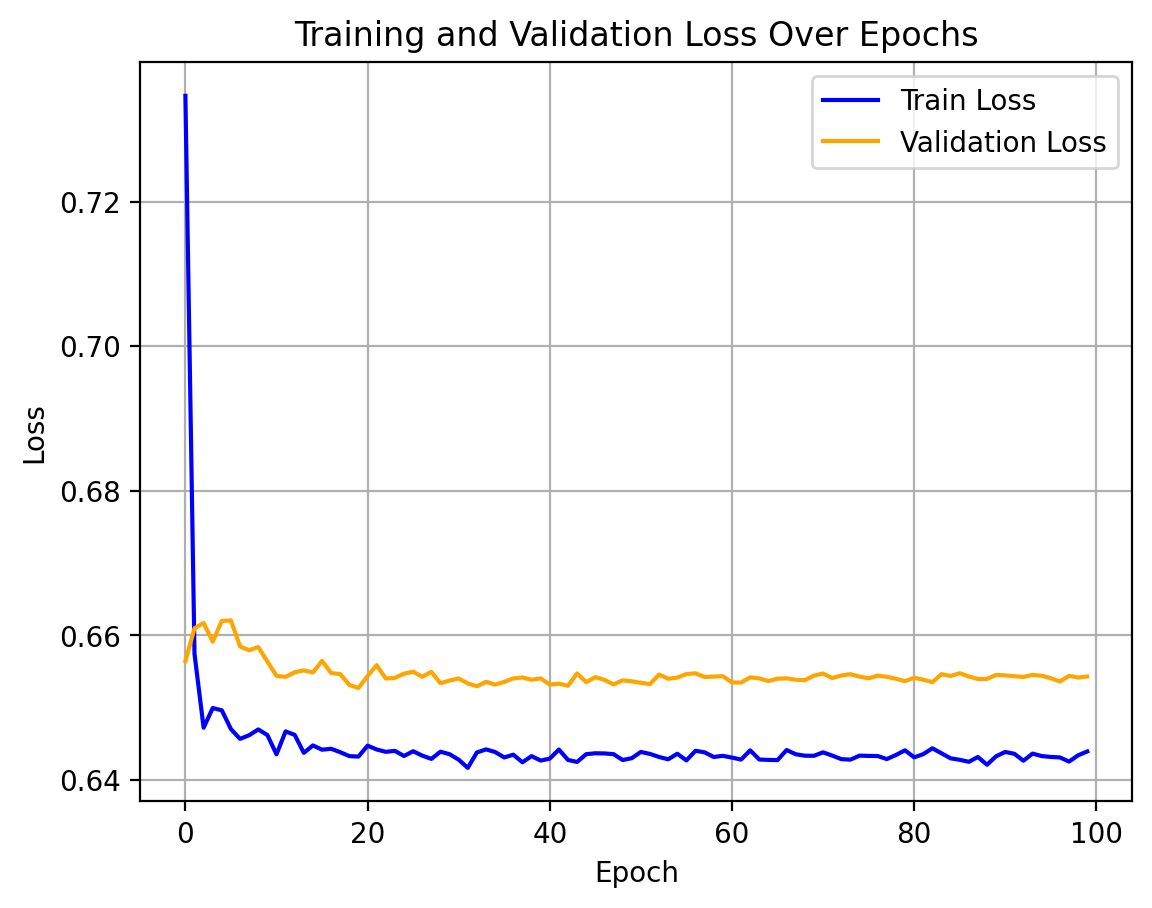

In [ ]:
import matplotlib.pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# Model
model_valence = ValenceNet().to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1] / class_weights[0])
optimizer = torch.optim.Adam(model_valence.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-06, weight_decay=1e-03)

# Training epochs
num_epochs = 100

# Save the best model during training CNN
saved_model_Valence = './best_model_valence.pkl'

# How often the network will be evaluated during training
evaluate_every_n_epochs = 2

# Train the model CNN
train(model_valence, train_loader, valid_loader, criterion, optimizer, num_epochs, saved_model_Valence, evaluate_every_n_epochs)

## Compute Valence on each 8-bar fragment

In [ ]:
# Use filtered fragments to label all the dataset with valence
fragmented_paths = list(Path("./FilteredD").glob("*.mid"))

path_labeled_per_fragment = []
mode_per_fragment = []
articulation_per_fragment = []
contour_per_fragment = []
valence_per_fragment = []
energy_per_fragment = []
mode_map = {'minor':0, 'major':1}

# Go through all the fragments
for j, midi_fragment in enumerate(fragmented_paths):
    a_mode, a_contour, a_art = get_musical_attributes_2(midi_fragment)
    try:
        a_energy = calculate_midi_energy(midi_fragment)
    except:
        continue

    # Store the information of each musical attribute. If there is any issue
    # skip this fragment
    if a_mode is not None:
        # Convert mode to number using map
        a_mode = mode_map[a_mode]

        # Append in a list the path and musical attributes: mode, rhythmic
        # articulation and contour
        path_labeled_per_fragment.append(midi_fragment)
        mode_per_fragment.append(a_mode)
        articulation_per_fragment.append(a_art)
        contour_per_fragment.append(a_contour)
        energy_per_fragment.append(a_energy)

        # Convert the musical attributes to a tensor
        #musical_attr = torch.tensor([a_mode, a_art, a_contour]).type(torch.float32)
        musical_attr = torch.tensor([a_mode, a_energy]).type(torch.float32).to(device)
        # Normalise attributes
        musical_attr = (musical_attr - train_mean.to(device)) / train_std.to(device)
        # Get the valence
        valence = model_valence(musical_attr)
        valence_per_fragment.append(valence.item())

    if j % 1000 == 0:
        print(f'Processed {j} fragments')

labeled_dataset_dict = {
    'path': path_labeled_per_fragment,
    'mode': mode_per_fragment,
    'articulation': articulation_per_fragment,
    'contour': contour_per_fragment,
    'energy': energy_per_fragment,
    'valence': valence_per_fragment
}

# Store dataset
with open('labeled_8bar_dataset_dict_clean.pkl', 'wb') as pickle_file:
    pickle.dump(labeled_dataset_dict, pickle_file)

In [ ]:
import re
import pickle

# Load dataset
with open('labeled_8bar_dataset_dict_clean.pkl', 'rb') as pickle_file:
    labeled_dataset_dict = pickle.load(pickle_file)

paths_dataset = labeled_dataset_dict['path']
mode_dataset = labeled_dataset_dict['mode']
art_dataset = labeled_dataset_dict['articulation']
countour_dataset = labeled_dataset_dict['contour']
energy_dataset = labeled_dataset_dict['energy']
valence_dataset = labeled_dataset_dict['valence']

# Create a dictionary with the path name as the key and the value as the index
paths_bar_dict = {}
for j, name in enumerate(paths_dataset):
    paths_bar_dict[name] = j

In [ ]:
# Our parameters
TOKENIZER_PARAMS = {
    "pitch_range": (21, 109),
    "beat_res": {(0, 4): 8, (4, 12): 4},
    "num_velocities": 32,
    "special_tokens": ["BOS", "EOS", "MASK"],
    "use_chords": True,
    "use_rests": False,
    "use_tempos": True,
    "use_time_signatures": False,
    "use_programs": False,
    "use_pitchdrum_tokens": False,
    "num_tempos": 32,  # number of tempo bins
    "tempo_range": (40, 250),  # (min, max)
}


remi = REMItokenizer(TOKENIZER_PARAMS, max_bar_embedding=None)

In [ ]:
# Dictionary to store the dataset format is:
# data_dict[current_name][bar_index]['ids'] = list of ids
#                        [bar_index]['valence'] = list of valence values per bar
#          [current_name][bar_index]['ids'] = list of ids
#                        [bar_index]['valence'] = list of valence values per bar

data_dict = {}
bar_dict = {}
max_len_ids = 0

# Vocabulary dictionary
vocab_dict = remi.get_vocab_dict()
# Get Bar id
bar_id = vocab_dict['Bar_None']

# Go through all the paths in the 8bar dataset
for j, path_8bar in enumerate(paths_dataset):
    current_name = re.sub(pattern, '', str(path_8bar)) + '.mid'

    # Tokenise and get ids
    current = MidiWav(path_8bar)
    tokenized_song = remi.tokenize_midi_file(current.midi_path)
    ids = tokenized_song[0].ids
    per_bar_ids = []
    per_bar_ids.append(ids[0])
    ids.pop(0)
    bars_ids_in_8bar = []
    for id in ids:
        if id == bar_id:
            bars_ids_in_8bar.append(per_bar_ids)
            per_bar_ids = []
        per_bar_ids.append(id)
    bars_ids_in_8bar.append(per_bar_ids)

    # Go through each bar of this 8-bar sequence
    for bar_index, bar_ids in enumerate(bars_ids_in_8bar):
        # Store the maximum size of the ids, used to decide the model dimensions
        if len(ids) > max_len_ids:
            max_len_ids = len(ids)

        # We are storing a dictionary with this bar path
        bar_dict[bar_index] = {}

        # Store the data of the current bar in the dictionary
        bar_dict[bar_index]['ids'] = bar_ids

        # Use the valence of the complete 8-bar sequence as the valence of this bar
        bar_dict[bar_index]['valence'] = valence_dataset[j]

    # Store the data in the dictionary
    data_dict[path_8bar] = bar_dict
    # Clear per bar dictionary
    bar_dict = {}

    # Print progress
    if j % 10000 == 0:
        print("Number of samples converted", j)

# Store dataset
with open('data_8bar_ids_dict_clean.pkl', 'wb') as pickle_file:
    pickle.dump(data_dict, pickle_file)

Number of samples converted 0
Number of samples converted 10000
Number of samples converted 20000
Number of samples converted 30000
Number of samples converted 40000
Number of samples converted 50000
Number of samples converted 60000


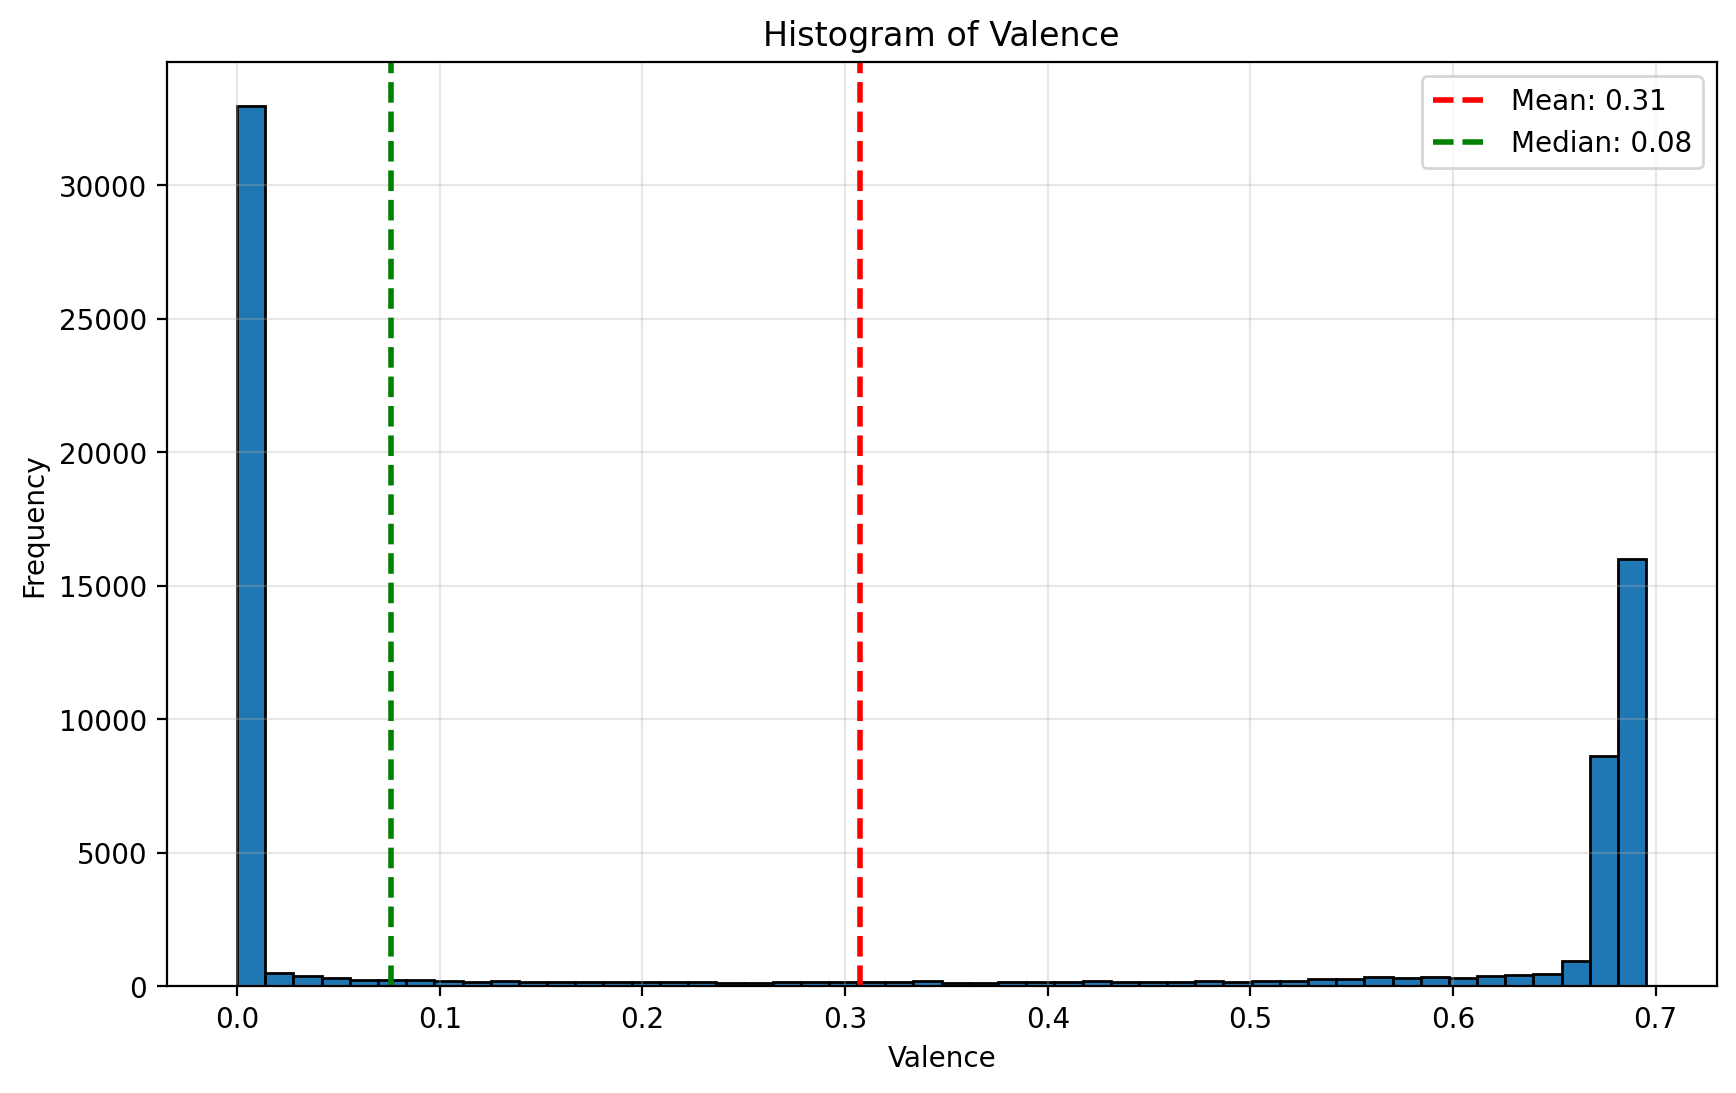

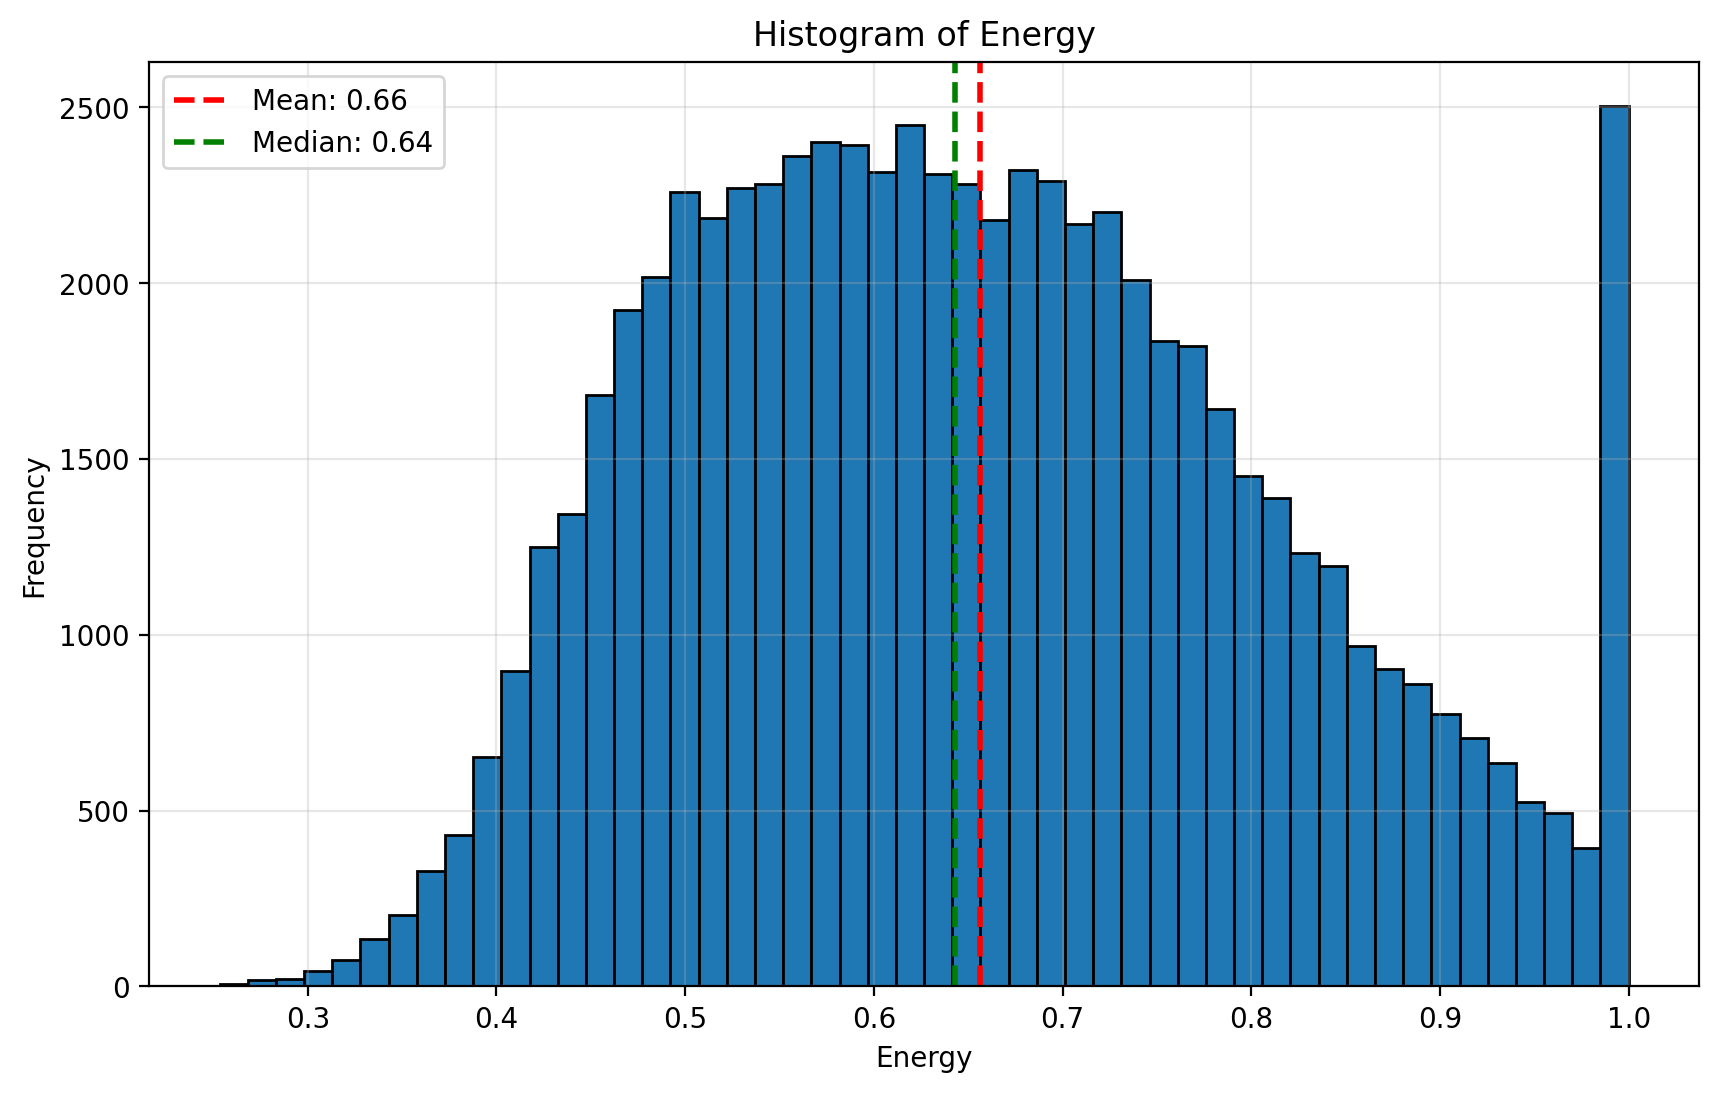

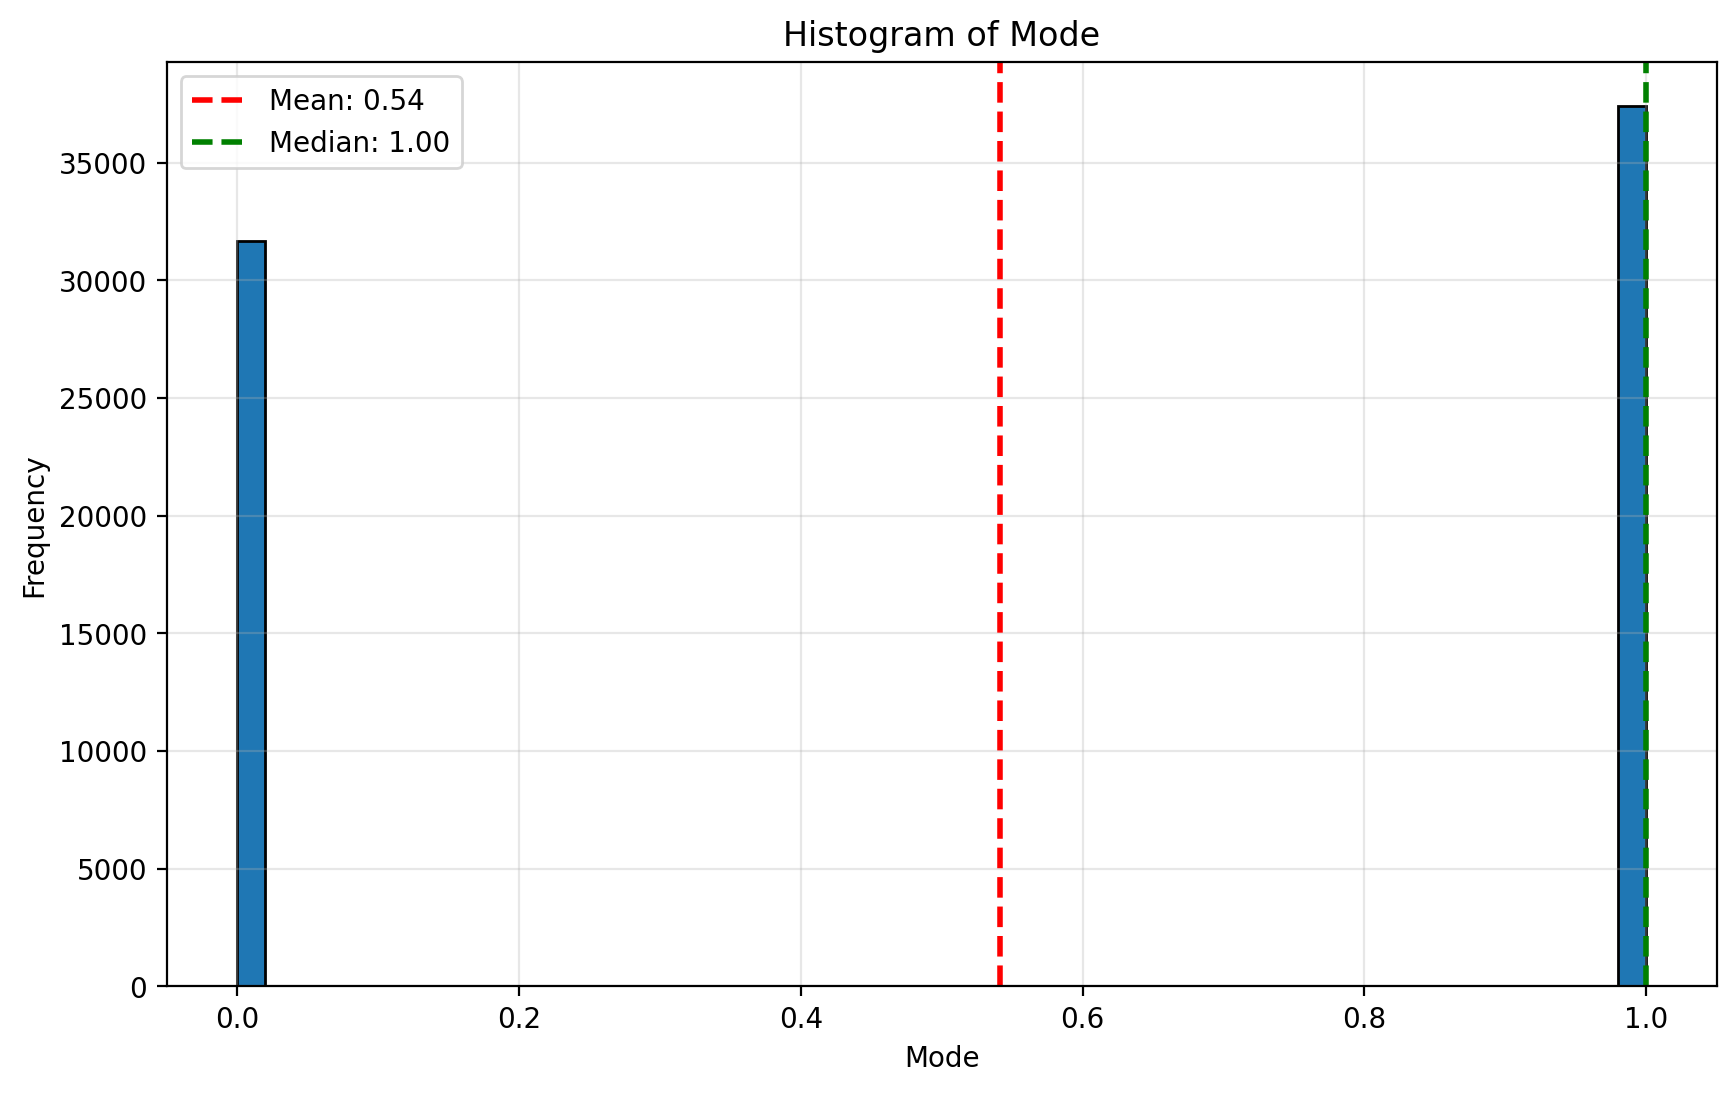

In [ ]:
# Supplementary material to plot histogram of features used to train ValenceNet
import matplotlib.pyplot as plt
import numpy as np

def plot_histogram(data_scores, title):
    plt.figure(figsize=(10, 6))

    # Create histogram
    n, bins, patches = plt.hist(data_scores, bins=50, edgecolor='black')

    # Add labels and title
    plt.xlabel(title)
    plt.ylabel('Frequency')
    plt.title('Histogram of ' + title)

    # Add grid
    plt.grid(alpha=0.3)

    # Add mean and median lines
    mean = np.mean(data_scores)
    median = np.median(data_scores)
    plt.axvline(mean, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
    plt.axvline(median, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')

    # Add legend
    plt.legend()

    # Show plot
    plt.show()

plot_histogram(valence_dataset, 'Valence')
plot_histogram(energy_per_fragment, 'Energy')
plot_histogram(mode_per_fragment, 'Mode')